In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

from pycbc import types
from pycbc import filter
from pycbc import psd

In [2]:
##Generate some White noise

#import parameters to track
N = 10000
T = 5000
dt = T / N
df = 1.0 / T
f_s = 1.0 / dt
f_nyq = f_s / 2.0

td_times = np.arange(0, T, dt)
td_noise = np.random.randn(N)

print('N:', N, 'dt:', dt,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

N: 10000 dt: 0.5 df: 0.0002 f_s: 2.0 f_nyq: 1.0


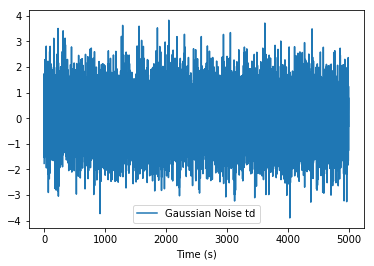

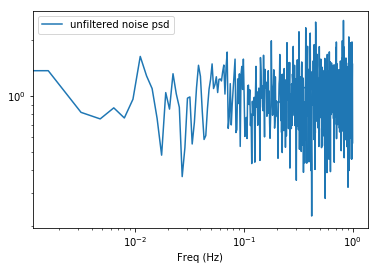

In [5]:
##Plot initial noise curve in the time domain

plt.figure(1)
plt.plot(td_times, td_noise, label='Gaussian Noise td')
plt.xlabel('Time (s)')
plt.legend()
plt.savefig('guassian_noise_td.png')

##Take the psd of the noise and plot fd as loglog

#convert td_noise to TimeSeries object
noise_ts = types.timeseries.TimeSeries(td_noise, delta_t = dt)

#take psd and plot
seg_len = int(noise_ts.duration) // 4 #higher number = more segments and increasing smoothing & decrease power
seg_stride = seg_len // 2 #50% overlap
noise_fs = psd.welch(noise_ts, seg_len= seg_len,
                     seg_stride = seg_stride)

plt.figure(2)
plt.loglog(noise_fs.sample_frequencies, noise_fs, label='unfiltered noise psd')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.savefig('gaussian_noise_fd.png')

plt.show()

#### Potential pycbc filters to try

###### types.TimeSeries module methods
- fir_zero_filter
- highpass_fir/
- lowpass_fir/
- notch_fir (notched filter)
- whiten (whitens timeseries)

###### filter.resample module methods
- resample_to_delta_t
- highpass/ - not sure how this one entirely differs from highpass_fir but the attentuated frequency curve is noticebly smoother
- highpass_fir (same as timeseries method)
- lowpass_fir (same as timeseries method)
- interpolate_complex_frequency

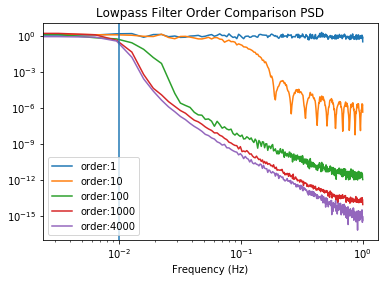

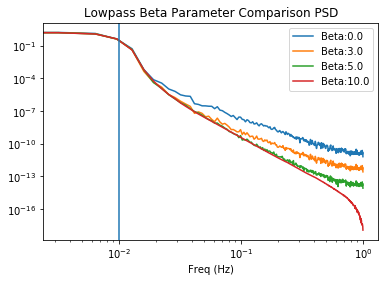

In [8]:
##Filter the white noise with a lowpass fir filter

#make copy
noise_ts1= noise_ts.copy()

##Adjust order of filter (parameter i)
w = 8
for i in [1, 10, 100, 1000, 4000]:
    #filter
    filtered = noise_ts1.lowpass_fir(0.01, i)
    
    #welch's method
    seg_len = int(noise_ts1.duration) // w
    #seg_len = int(4 / dt)
    seg_stride = seg_len // 2
    noise_fs = psd.welch(filtered, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs, label=('order:'+str(i)))

plt.legend()
plt.title("Lowpass Filter Order Comparison PSD")
plt.xlabel('Frequency (Hz)')
plt.axvline(0.01)
plt.savefig('lowpass_psd_order_comparison.png')

plt.figure()

##Adjust Beta parameter of filter
noise_ts1 = noise_ts1.copy()
for i in [0.0, 3.0, 5.0, 10.0]:
    
    #order set to 1000
    filtered = noise_ts1.lowpass_fir(0.01, 1000, beta=i)
    
    #welch's method
    seg_len = int(noise_ts1.duration) // w
    seg_stride = seg_len // 2
    noise_fs = psd.welch(filtered, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs, label=('Beta:'+str(i)))
    
plt.legend()
plt.title('Lowpass Beta Parameter Comparison PSD')
plt.xlabel('Freq (Hz)')
plt.axvline(0.01)
plt.savefig('lowpass_psd_beta_comparison.png')

plt.show()

##### timeseries_name.pycbc.types.timeseries.TimeSeries.lowpass_fir(freq, order, beta=5.0, remove_corrupted=True)

The lowpass filter used above intakes parameters:
- Freq - (float) below which to suppress 
    - changing this changes where the attenuation begins at any frequency greater than this.
- Order - (int) number of samples of signal to use in creating the filtered signal. Shown in second equation of [x](https://en.wikipedia.org/wiki/Finite_impulse_response)
    - changing this changes the slope for the attenuation power at frequencies greater than the cutoff.
    - larger numbers create a curve that gets increasingly linear.
    - cannot exceed the number of samples to either side of the cutoff (?)   
- beta - (float) Beta parameter of kaiser window.
    - changing this seems to provide smoothing as well and affect drop off rate (since it has to do with the windowing, it makes sense)
    - anything more specific?

###### timeseries_name.pycbc.types.timeseries.TimeSeries.highpass_fir(freq, order, beta=5.0, remove_corrupted=True)

Same parameters as the lowpass filter.

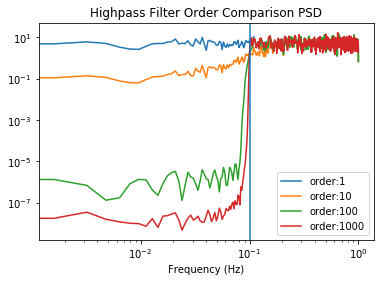

In [ ]:
##Highpass filter experimentation

#make copy of Gaussian white noise
noise_ts2= noise_ts.copy()

#alternatively, uniform white noise
noise_ts2 = np.random.uniform(-4, 4, size = N)
noise_ts2 = types.timeseries.TimeSeries(noise_ts2, delta_t=dt)

##Take the filter

#Adjust order of filter (parameter i)
for i in [1, 10, 100, 1000]:
    
    #filter with cutoff freq = 0.1
    filtered = noise_ts2.highpass_fir(0.1, i)
    
    #welch's method
    seg_len = int(noise_ts2.duration) // 4
    seg_stride = seg_len // 2
    noise_fs = psd.welch(filtered, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs, label=('order:'+str(i)))

plt.legend()
plt.title("Highpass Filter Order Comparison PSD")
plt.xlabel('Frequency (Hz)')
plt.axvline(0.1)
plt.savefig('highpass_psd_order_comparison.png')

plt.figure()

##Beta parameter adjustment
for i in [0.0, 3.0, 5.0, 10.0]:
    
    #order set to 1000
    filtered = noise_ts2.highpass_fir(0.1, 1000, beta=i)
    
    #welch's method
    seg_len = int(noise_ts2.duration) // 4
    seg_stride = seg_len // 2
    noise_fs = psd.welch(filtered, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs, label=('Beta:'+str(i)))
    
plt.legend()
plt.savefig('highpass_psd_beta_comparison.png')

plt.show()

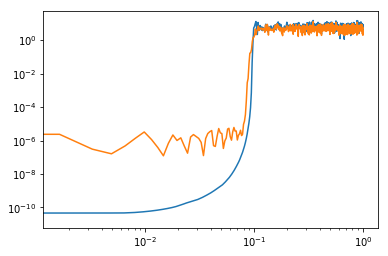

In [11]:
##Comparison with Highpass and Highpass_fir
test1 = filter.resample.highpass(noise_ts2, 0.1, filter_order = 100)
test2 = noise_ts2.highpass_fir(0.1, 100)

#highpass (not fir) might have an automatic beta parameter that's much higher
#than the default of highpass_fir

plt.figure()
for i in [test1, test2]:
    
    seg_len = int(i.duration) // 4
    seg_stride = seg_len // 2
    noise_fs = psd.welch(i, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs)

plt.show()

In [9]:
##Try some additional filter types available

##Generate some new White noise with a higher f_s

#import parameters to track
N = 10000
T = 500
dt = T / N
df = 1.0 / T
f_s = 1.0 / dt
f_nyq = f_s / 2.0

td_times = np.arange(0, T, dt)
td_noise = np.random.randn(10000)

print('N:', N, 'dt:', dt,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

N: 10000 dt: 0.05 df: 0.002 f_s: 20.0 f_nyq: 10.0


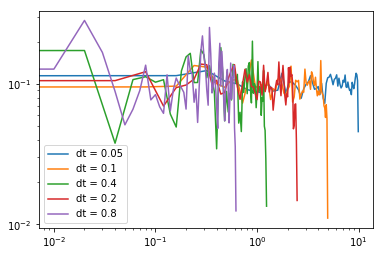

In [10]:
##Resample to delta t

noise_ts = types.timeseries.TimeSeries(td_noise, delta_t = dt)

for i in [dt, 0.1, 0.4, 0.2, 0.8]:
    #filter (original dt = 0.5), only powers of two are supported
    filtered = filter.resample.resample_to_delta_t(noise_ts, 
                                                   delta_t=i)
    
    #welch's method
    seg_len = int(noise_ts.duration) // 4
    seg_stride = seg_len // 2
    noise_fs = psd.welch(filtered, seg_len = seg_len,
                        seg_stride = seg_stride)
    
    plt.loglog(noise_fs.sample_frequencies, noise_fs, label=('dt = '+str(i)))
    
plt.legend()
plt.savefig('resampling_filter_psd.png')
plt.show()

N: 10000 dt: 0.5 df: 0.0002 f_s: 2.0 f_nyq: 1.0


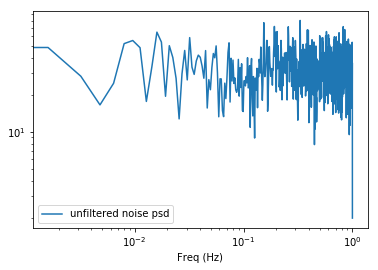

In [35]:
##Play around with noise signal parameters to see how it affect the generated noise psd

#import parameters to track
N = 10000
T = 5000
dt = T / N
df = 1.0 / T
f_s = 1.0 / dt
f_nyq = f_s / 2.0

td_times = np.arange(0, T, dt)
td_noise = np.random.uniform(-10, 10, N)

print('N:', N, 'dt:', dt,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

#convert td_noise to TimeSeries object
noise_ts = types.timeseries.TimeSeries(td_noise, delta_t = dt)

##Take psd and plot
seg_len = int(noise_ts.duration) // 4 #higher number = more segments and increasing smoothing & decrease power
#seg_len = int(4 / dt)
seg_stride = int(seg_len // 2) #50% overlap
noise_fs = psd.welch(noise_ts, seg_len= seg_len,
                     seg_stride = seg_stride)

plt.figure(2)
plt.loglog(noise_fs.sample_frequencies, noise_fs, label='unfiltered noise psd')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.savefig('gaussian_noise_fd.png')

plt.show()